In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import seaborn as sns
from intercluster.plotting import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 18
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)



subset_colors = [cmap(0), cmap(5), cmap(1), cmap(3), cmap(6), cmap(7)]
cmap_subset = ListedColormap(subset_colors)

no_oblique_subset_colors = [cmap(0), cmap(5), cmap(1), cmap(6), cmap(7)]
no_oblique_cmap_subset = ListedColormap(no_oblique_subset_colors)

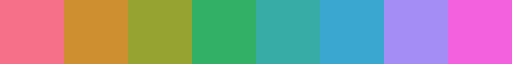

In [58]:
cmap

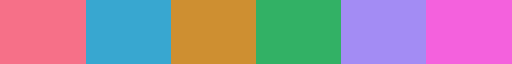

In [59]:
cmap_subset

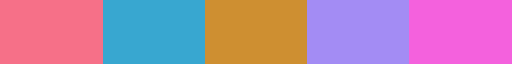

In [56]:
no_oblique_cmap_subset

### Coverage-Cost Experiments

In [168]:
fname = "../data/experiments/climate/coverage_exp_bsearch.csv"
experiment_df = pd.read_csv(fname, header=[0, 1, 2], index_col=0)

In [169]:
# Computing statistics:
grouped = experiment_df.T.groupby(level = [0,1])
mean_df = grouped.mean().T
std_df = grouped.std().T

In [170]:
mean_df

coverage                                                        \
   ExKMC-Forest    Forest Forest-Depth-IMM  IMM KMeans Oblique-Forest   
0      0.634620  0.620291         0.769767  1.0    1.0       0.659419   
1      0.683200  0.620291         0.769767  1.0    1.0       0.659419   
2      0.723933  0.624390         0.769767  1.0    1.0       0.660029   
3      0.758581  0.727587         0.769767  1.0    1.0       0.678401   
4      0.793915  0.800785         0.769767  1.0    1.0       0.721715   
5      0.823770  0.817442         0.770494  1.0    1.0       0.786919   
6      0.845425  0.824855         0.815203  1.0    1.0       0.847355   
7      0.872416  0.861279         0.863430  1.0    1.0       0.884244   
8      0.910853  0.914855         0.911860  1.0    1.0       0.918983   
9           NaN  0.955145         0.960494  1.0    1.0       0.961802   
10          NaN  1.000000         1.000000  1.0    1.0       1.000000   

                         distance-ratio            ...  \
         SVM Voronoi-Set   ExKMC-Forest    Forest  ...   
0   0.529477    0.595116       0.996636  1.207121  ...   
1   0.575436    0.619477       0.998410  1.207121  ...   
2   0.778721    0.641541       0.996700  1.207991  ...   
3   0.814099    0.708430       0.997738  1.219473  ...   
4   0.814099    0.740814       0.996779  1.235073  ...   
5   0.816076    0.786657       0.996898  1.244501  ...   
6   0.823721    0.837180       1.000248  1.248732  ...   
7   0.859855    0.872442       1.002255  1.243903  ...   
8   0.905138    0.913779       0.997274  1.240453  ...   
9        NaN    0.971860            NaN  1.268275  ...   
10       NaN    1.000000            NaN  1.077192  ...   

   point-average-clustering-cost              weighted-average-rule-length  \
                             SVM  Voronoi-Set                 ExKMC-Forest   
0                    2261.015855  2369.537877                     6.213410   
1                    2487.322320  2448.368317                     6.210645   
2                    3152.678303  2566.846859                     6.169352   
3                    3265.138656  2912.770030                     6.113432   
4                    3265.138656  3050.895908                     6.074497   
5                    3269.406314  3260.170923                     6.016411   
6                    3303.298634  3473.197953                     5.994893   
7                    3486.515085  3697.174752                     5.940338   
8                    3805.675926  3944.644483                     5.928021   
9                            NaN  4255.874621                     5.927209   
10                           NaN  6640.844579                     5.927209   

                                                                                
      Forest Forest-Depth-IMM       IMM KMeans Oblique-Forest  SVM Voronoi-Set  
0   1.944292         2.887740  3.645349    NaN            2.0  1.0         2.0  
1   1.944292         2.887740  3.645349    NaN            2.0  1.0         2.0  
2   1.944727         2.887740  3.645349    NaN            2.0  1.0         2.0  
3   1.952290         2.887740  3.645349    NaN            2.0  1.0         2.0  
4   1.957968         2.887740  3.645349    NaN            2.0  1.0         2.0  
5   1.964091         2.887874  3.645349    NaN            2.0  1.0         2.0  
6   1.966292         2.898480  3.645349    NaN            2.0  1.0         2.0  
7   2.000000         2.922215  3.645349    NaN            2.0  1.0         2.0  
8   2.000000         2.924156  3.645349    NaN            2.0  1.0         2.0  
9   2.000000         2.931667  3.645349    NaN            2.0  1.0         2.0  
10  1.987272         2.871345  3.645349    NaN            2.0  1.0         2.0  

[11 rows x 56 columns]

In [164]:
table_df = mean_df.iloc[-3,:].to_frame()
table_df

8
coverage                      ExKMC-Forest         0.910853
                              Forest               0.914855
                              Forest-Depth-IMM     0.911860
                              IMM                  1.000000
                              KMeans               1.000000
                              Oblique-Forest       0.918983
                              SVM                  0.905138
                              Voronoi-Set          0.913779
distance-ratio                ExKMC-Forest         0.997274
                              Forest               1.240453
                              Forest-Depth-IMM     1.276784
                              IMM                       NaN
                              KMeans                    NaN
                              Oblique-Forest       1.210905
                              SVM                  1.232183
                              Voronoi-Set          1.272771
max-rule-length               ExKMC-Forest         7.320000
                              Forest               2.000000
                              Forest-Depth-IMM     3.000000
                              IMM                  5.000000
                              KMeans                    NaN
                              Oblique-Forest       2.000000
                              SVM                  1.000000
                              Voronoi-Set          2.000000
normalized-clustering-cost    ExKMC-Forest        15.393780
                              Forest              11.995593
                              Forest-Depth-IMM    11.753711
                              IMM                 12.302270
                              KMeans              11.660925
                              Oblique-Forest      12.305407
                              SVM                 12.222213
                              Voronoi-Set         12.547437
overlap                       ExKMC-Forest         1.000000
                              Forest               1.080289
                              Forest-Depth-IMM     1.031023
                              IMM                  1.000000
                              KMeans               1.000000
                              Oblique-Forest       1.096772
                              SVM                  1.090647
                              Voronoi-Set          1.124828
point-average-clustering-cost ExKMC-Forest      4823.554268
                              Forest            3775.875668
                              Forest-Depth-IMM  3686.962008
                              IMM               4231.980754
                              KMeans            4011.358182
                              Oblique-Forest    3891.086534
                              SVM               3805.675926
                              Voronoi-Set       3944.644483
weighted-average-rule-length  ExKMC-Forest         5.928021
                              Forest               2.000000
                              Forest-Depth-IMM     2.924156
                              IMM                  3.645349
                              KMeans                    NaN
                              Oblique-Forest       2.000000
                              SVM                  1.000000
                              Voronoi-Set          2.000000

### Plotting

In [171]:
#colormap = no_oblique_cmap_subset
colormap = cmap_subset
baseline_list = ['KMeans', 'IMM']
module_list = [m for m in mean_df['normalized-clustering-cost'].columns if m not in baseline_list]

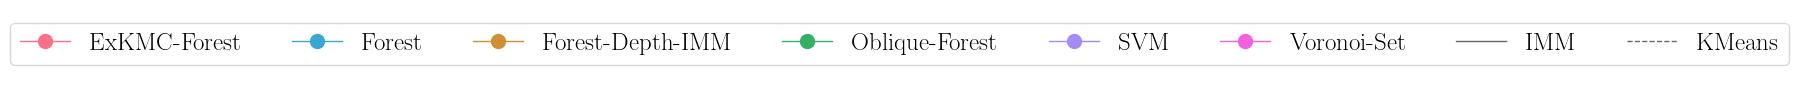

In [167]:
# Legend:
fig, ax = plt.subplots(figsize = (6,1))
legend_elements = [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=10,
        color=colormap(i),
        lw=1,
        label=mod,
        alpha=1
    )
    for i,mod in enumerate(module_list)
]

legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=1,
        linestyle = '-',
        label="IMM",
        alpha=0.6
    )
]

legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=1,
        linestyle = 'dashed',
        label="KMeans",
        alpha=0.6
    )
]

ax.legend(handles=legend_elements, ncol=len(module_list) + len(baseline_list))
ax.axis('off')
plt.savefig('../figures/coverage/legend.png', bbox_inches = 'tight', dpi = 300)

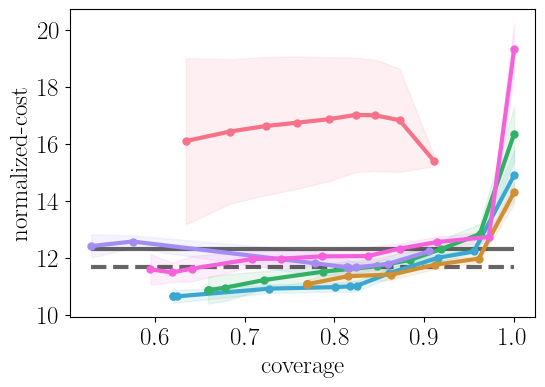

In [172]:
fname = None
fname = '../figures/coverage/digits.png'
experiment_plotter(
    mean_df['normalized-clustering-cost'],
    std_df['normalized-clustering-cost'],
    domain_df = mean_df['coverage'],
    xlabel = 'coverage',
    ylabel = 'normalized-cost',
    cmap = colormap,
    baseline_list = ['KMeans', 'IMM'],
    legend = False,
    filename = fname,
)
#plt.ylim(10,14)

(10.0, 14.0)

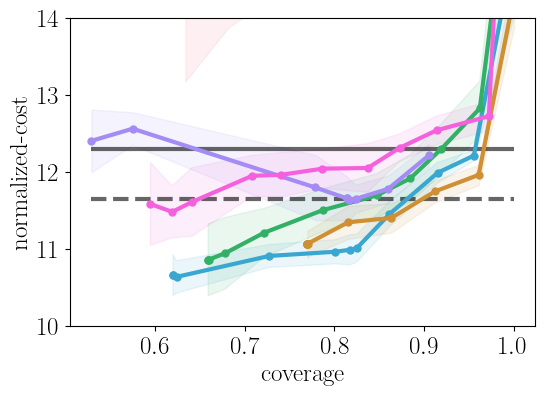

In [147]:
fname = None
#fname = '../figures/coverage/fashion.png'
experiment_plotter(
    mean_df['normalized-clustering-cost'],
    std_df['normalized-clustering-cost'],
    domain_df = mean_df['coverage'],
    xlabel = 'coverage',
    ylabel = 'normalized-cost',
    cmap = colormap,
    baseline_list = ['KMeans', 'IMM'],
    legend = False,
    filename = fname,
)
plt.ylim(10,14)

In [17]:
mean_df['distance-ratio']

,ExKMC-Forest,Forest,Forest-Depth-5,IMM,KMeans,SVM-Forest,Voronoi-Set
0,inf,1.638676,1.495841,1.594826,1.596493,inf,1.592836
1,inf,1.638676,1.495841,1.594826,1.596493,inf,1.592836
2,inf,1.613986,1.495841,1.594826,1.596493,1.749947,1.592836
3,inf,1.599610,1.495841,1.594826,1.596493,1.680446,1.592836
4,inf,1.590175,1.495841,1.594826,1.596493,1.625645,1.588021
5,inf,1.584477,1.495841,1.594826,1.596493,1.605630,1.571792
6,inf,1.544779,1.547680,1.594826,1.596493,1.574870,1.548586
7,inf,1.521701,1.546777,1.594826,1.596493,1.514120,1.506670
8,inf,1.498935,1.512124,1.594826,1.596493,1.391058,1.488403
9,inf,1.499270,1.455912,1.594826,1.596493,NaN,1.427247


### Covered Cost

In [53]:
df = pd.read_csv("../data/experiments/decision_sets/rules_cost_comparison_climate.csv", header=[0, 1, 2], index_col=0)
grouped = df.T.groupby(level = [0,1])
mean_df2 = grouped.mean().T
std_df2 = grouped.std().T

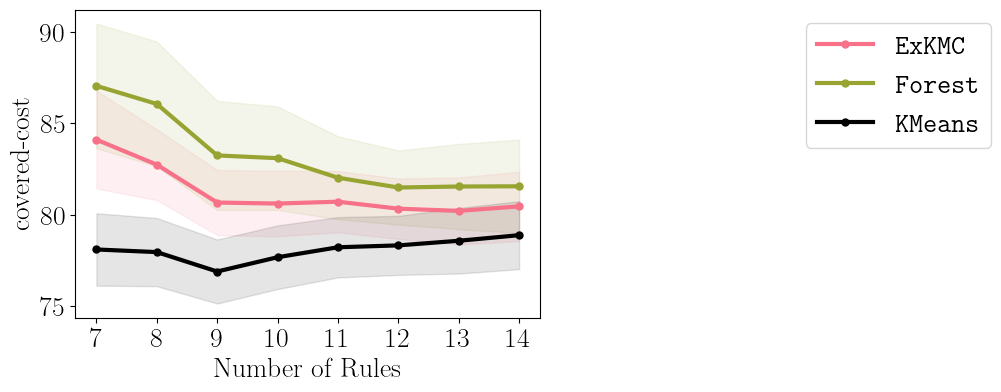

In [61]:
covered_cost_colors = [cmap(0), cmap(2), 'black']
covered_cost_colormap = ListedColormap(covered_cost_colors)

fname = None
fname = '../figures/climate/forest_covered_cost.png'
experiment_plotter(
    mean_df2['point-average-clustering-cost'],
    std_df2['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'covered-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = covered_cost_colormap,
    legend = True,
    filename = fname,
    baseline_list = []
)

In [59]:
df = pd.read_csv("../data/experiments/decision_sets/rules_cost_comparison_climate_depth_5.csv", header=[0, 1, 2], index_col=0)
grouped = df.T.groupby(level = [0,1])
mean_df3 = grouped.mean().T
std_df3 = grouped.std().T

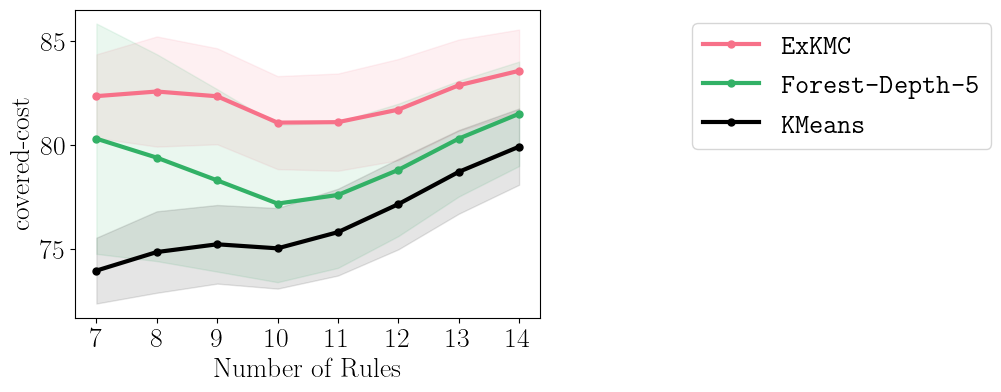

In [62]:
covered_cost_colors = [cmap(0), cmap(3), 'black']
covered_cost_colormap2 = ListedColormap(covered_cost_colors)

fname = None
fname = '../figures/climate/forest_d5_covered_cost.png'
experiment_plotter(
    mean_df3['point-average-clustering-cost'],
    std_df3['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'covered-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = covered_cost_colormap2,
    legend = True,
    filename = fname,
    baseline_list = []
)